#  Homework 5 - Berkeley STAT 157

**Your name: Luyu Chen, SID 3034306110

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 


In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import random
import mxnet as mx

In [1]:
mnist_train = gdata.vision.FashionMNIST(train=True,transform=lambda data, label: (data.astype(np.float32), label))
mnist_test = gdata.vision.FashionMNIST(train=False,transform=lambda data, label: (data.astype(np.float32), label))

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

In [207]:
# problem 1
def loss(y,o):
    ## add your loss function here
    l = - nd.log(1 + nd.exp(- nd.dot(y, o)))
    return l

In [208]:
#Problem 2
import matplotlib.pyplot as plt
o = nd.arange(-5, 5, 0.01).reshape((1,1000))
y = nd.array([1])
l = loss(y, o)

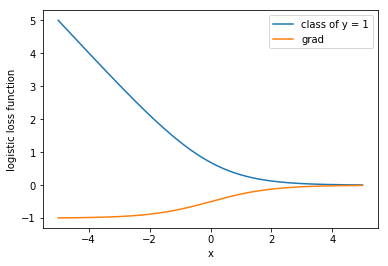

In [209]:
onp = o.asnumpy()[0]
plt.plot(onp,-l.asnumpy(), label = 'class of y = 1')
plt.xlabel('x')
plt.ylabel('logistic loss function')

o.attach_grad()
with autograd.record():
    func = -loss(y,o)
func.backward()
plt.plot(onp,o.grad.asnumpy().reshape(1000,),label = 'grad')
plt.xlabel('x')
plt.legend(loc = 'best')

plt.legend(loc = 'best')
plt.show()

### Train dataset and Test dataset

In [2]:
def generate_data(mnist_train, mnist_test,bias, total):
    '''
    biased ratio is for problem 3
    total would be the total sample for each class.
    '''
    
    X, y = mnist_train[:]
    coat =  np.where(y == 4)[0].tolist()
    shirt = np.where(y == 6)[0].tolist()
    sandal = np.where(y == 5)[0].tolist()
    sneaker = np.where(y == 7)[0].tolist()
    
    class1_portion = round(bias * total)
    class2_portion = round((1 - bias) * total)
    
    #for train dataset
    #index_coat = random.sample(coat, class1_portion)
    #index_shirt = random.sample(shirt, class1_portion)
    #index_sandal = random.sample(sandal, class2_portion)
    #index_sneaker = random.sample(sneaker, class2_portion)
    
    index_coat = coat[0:class1_portion]
    index_shirt = shirt[0:class1_portion]
    index_sandal = sandal[0:class2_portion]
    index_sneaker = sneaker[0:class2_portion]
    
    train_coat = X[index_coat]
    train_shirt = X[index_shirt]
    train_sandal = X[index_sandal]
    train_sneaker = X[index_sneaker]
     
    train_feature = nd.concat(train_coat,train_shirt, train_sandal, train_sneaker, dim=0)
    label1 = nd.ones((1, total)).astype(np.float32)
    label2 = nd.zeros((1, total)).astype(np.float32)
    
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    
    #for test dataset    
    A, b = mnist_test[:]
    indices_1 = np.where(np.logical_or(b == 4, b == 6))[0].tolist() #coat and shirt
    indices_2 = np.where(np.logical_or(b == 5, b == 7))[0].tolist() #sandal and sneaker

    class1 = A[indices_1] #class1
    class0 = A[indices_2] #class-1
    test_feature = nd.concat(class1, class0,dim = 0)
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label0 = nd.zeros((1,2000)).astype(np.float32)
    test_label = nd.concat(label1,label0,dim = 1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_label)    
    return train_data, test_data

### Train all samples

In [61]:
import d2l,random
train_all, test_all = generate_data(mnist_train, mnist_test,0.5, 12000)

In [62]:
def model(train, test, batch_size, lr, num_epochs):
    train_iter = gdata.DataLoader(train, batch_size,shuffle = True)
    test_iter = gdata.DataLoader(test, batch_size,shuffle = True)

    net = nn.Sequential()
    net.add(nn.Dense(2))
    net.initialize(init.Normal(sigma=0.01))

    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)

In [64]:
model(train_all, test_all, 256, 0.1, 5)

epoch 1, loss 1600.7892, train acc 0.985, test acc 0.997
epoch 2, loss 29.9104, train acc 0.998, test acc 0.999
epoch 3, loss 22.9545, train acc 0.998, test acc 0.999
epoch 4, loss 19.6463, train acc 0.999, test acc 0.999
epoch 5, loss 16.3328, train acc 0.999, test acc 0.999


### Train half sample

In [65]:
train_half, test_half = generate_data(mnist_train, mnist_test,0.5, 6000)

In [66]:
model(train_half, test_half, 256, 0.1, 5)

epoch 1, loss 657.3146, train acc 0.966, test acc 0.993
epoch 2, loss 108.0598, train acc 0.996, test acc 0.995
epoch 3, loss 60.3451, train acc 0.998, test acc 0.997
epoch 4, loss 46.4209, train acc 0.998, test acc 0.998
epoch 5, loss 37.1828, train acc 0.998, test acc 0.999


## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `shirt` and `sweater` and of `sandal` and `sneaker` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `shirt` and $600$ `sweater` images and likewise $5,400$ `sandal` and $5,400$ `sneaker` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `shirt` + `sweater` category and of the `sandal` + `sneaker` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [67]:
lam = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

In [68]:
for i in lam:
    train_shift, test_shift = generate_data(mnist_train, mnist_test,i, 6000)
    print('Bias is %.2f' %i)
    model(train_shift, test_shift, 256, 0.1, 5)

Bias is 0.05
epoch 1, loss 13746.6903, train acc 0.763, test acc 0.797
epoch 2, loss 6300.7187, train acc 0.854, test acc 0.796
epoch 3, loss 5795.2292, train acc 0.859, test acc 0.770
epoch 4, loss 5044.2806, train acc 0.875, test acc 0.747
epoch 5, loss 4329.9004, train acc 0.884, test acc 0.761
Bias is 0.10
epoch 1, loss 14772.2570, train acc 0.773, test acc 0.816
epoch 2, loss 8150.8907, train acc 0.815, test acc 0.799
epoch 3, loss 7333.8877, train acc 0.830, test acc 0.833
epoch 4, loss 6591.5090, train acc 0.840, test acc 0.939
epoch 5, loss 7271.4670, train acc 0.845, test acc 0.763
Bias is 0.20
epoch 1, loss 14084.8478, train acc 0.749, test acc 0.979
epoch 2, loss 8517.7672, train acc 0.793, test acc 0.787
epoch 3, loss 7954.2751, train acc 0.798, test acc 0.829
epoch 4, loss 7248.9983, train acc 0.801, test acc 0.796
epoch 5, loss 7526.5245, train acc 0.802, test acc 0.985
Bias is 0.30
epoch 1, loss 12895.3116, train acc 0.769, test acc 0.719
epoch 2, loss 7464.9982, train a

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


#### Answer
1. If different size, $p(x)$ is the unbiased testing set. $q(x)$ is the biased training set. $\beta(x)$ here is the weight.  
$$\int p(x)f(x)dx = \int q(x)f(x)\beta(x)dx $$ 
Weighting should be: $$\beta(x_{class1}) = \frac{p(x)}{q(x)} = \frac{\frac{N_{class=1}}{N_{test}}}{\frac{N_{class=1}}{N_{trian}}} = \frac{0.5}{0.1} = 5$$   
$$\beta(x_{class0}) = \frac{p(x)}{q(x)} = \frac{\frac{N_{class=0}}{N_{test}}}{\frac{N_{class=0}}{N_{trian}}} = \frac{0.5}{0.9} = \frac{5}{9}$$

### Give training set label 1 and testing set label 0.

In [48]:
def generator(ratio, batch_size):
    mnist_train = gdata.vision.FashionMNIST(train=True,transform=lambda data, label: (data.astype(np.float32)/255.0, label))
    mnist_test = gdata.vision.FashionMNIST(train=False,transform=lambda data, label: (data.astype(np.float32)/255.0, label))
    bias_train, bias_test = generate_data(mnist_train, mnist_test,ratio, 6000)
    #train's label should be 1 and test's label should be 0
    f_train, l_train = bias_train[:]
    f_test, l_test = bias_test[:]
    
    l_train = nd.ones((1, 12000)).astype(np.float32) 
    l_test = nd.zeros((1,4000)).astype(np.float32)
    
    trainLabel = nd.concat(l_train[:,:8000],l_test[:,:3000],dim = 1).reshape(shape=(-1,))
    testLabel = nd.concat(l_train[:,8000:],l_test[:,3000:],dim = 1).reshape(shape=(-1,))
    trainFeature = nd.concat(f_train[:8000], f_test[:3000], dim = 0)
    testFeature = nd.concat(f_train[8000:], f_test[3000:], dim = 0)

    trainDataset = gdata.dataset.ArrayDataset(trainFeature, trainLabel) 
    testDataset = gdata.dataset.ArrayDataset(testFeature, testLabel) 
    
    train = gluon.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
    test = gluon.data.DataLoader(testDataset, batch_size=batch_size, shuffle=True)
    return train, test

### Not very high accuracy for binary classification
* Encoutered problem regrading to calculation of loss.When iterating, the loss became 0.0 for lambda = 0.1. Somehow, I stuck here and I use lambda = 0.2 to train the classification  
* I understand the logic behind the covariate shift.   
    1. There is only one output here and it would be class 1. I have already generating a dataset with data from training set labeled as 1, and data from testing set labeled as 0. The weight here should be 5 adding to the loss function.   
    2. find the function $f$, which is trained by the Gluon net (a linear function) using the binary classification implemented in problem 2.   
    3. Weigh training data using $$\beta_i = min(\exp(f(x_i)),c)$$    
    and c would be a ceiling preventing the exponential function to be NAN   
    4. Using the weights $\beta_i$ for training on X with labels Y, which is problem 4.

### Define Logistic function and Loss function    
reference from Gluon tutorial: Binary Classification with Logistic Regression   

In [49]:
def logistic(z):
    return 1. / (1. + nd.exp(-z))

def log_loss(output, y, ratio):
    yhat = logistic(output)
    yhat = yhat.reshape(shape=y.shape)
    return  - nd.nansum(.5/ratio * y * nd.log(yhat) + .5/(1-ratio) * (1-y) * nd.log(1-yhat))

### Training and Testing

In [50]:
def train_model(epochs, train_data, net, trainer, batch_size, ratio):
    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            with autograd.record():
                output = net(data)
                loss = log_loss(output, label, ratio)
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        print("Epoch %s, loss: %s" % (e, cumulative_loss ))


def test_model(test_data):
    num_correct = 0.0
    num_total = 0
    for i, (data, label) in enumerate(test_data):
        num_total += len(label)
        output = net(data)
        prediction = ((nd.sign(output).reshape(shape=label.shape) + 1) / 2)
        num_correct += nd.sum(prediction == label)
    print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

In [60]:
batch_size = 64
total_per_label = 6000
ratio = 0.2
num_epochs = 20
net = nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=.01))
train_data, test_data = generator(ratio, batch_size)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02})
train_and_test_mnist_ratio(train_data, test_data, net, trainer, num_epochs, batch_size, ratio)

Epoch 0, loss: 6826.333644866943
Epoch 1, loss: 5480.05650138855
Epoch 2, loss: 5035.953670501709
Epoch 3, loss: 4794.918685913086
Epoch 4, loss: 4639.720854759216
Epoch 5, loss: 4526.004120826721
Epoch 6, loss: 4443.828551292419
Epoch 7, loss: 4380.837176322937
Epoch 8, loss: 4325.9956884384155
Epoch 9, loss: 4283.962030410767
Epoch 10, loss: 4246.276669502258
Epoch 11, loss: 4215.988206863403
Epoch 12, loss: 4186.381437301636
Epoch 13, loss: 4161.560842514038
Epoch 14, loss: 4142.281621932983
Epoch 15, loss: 4117.475589752197
Epoch 16, loss: 4106.954483032227
Epoch 17, loss: 4087.5182552337646
Epoch 18, loss: 4076.430640220642
Epoch 19, loss: 4062.342698097229
Accuracy: 0.743 (2972.0/4000)


### Problem 3.3